In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns




/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_json("/kaggle/input/imdb-spoiler-dataset/IMDB_reviews.json", lines=True)
  

In [3]:
#sampling the Dataset
sample_percentage = 10

# Calculate the number of rows to sample
num_samples = int(len(df) * (sample_percentage / 100))
# num_samples = df.head(10000)




In [4]:
# Randomly sample the DataFrame   
sampled_df = df.sample(n=num_samples, random_state=42)
sampled_df = df.head(15000)
labels = sampled_df.is_spoiler.values
sentences = sampled_df.review_text.values

# Split the dataset into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    sentences, labels, test_size=0.3, random_state=42
)

In [5]:

# BERT Tokenization and Encoding
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model_bert = TFBertModel.from_pretrained(model_name)



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [6]:
# Tokenize and encode the training and testing data for BERT
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, return_tensors='tf')
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, return_tensors='tf')



In [7]:
# Convert labels to TensorFlow tensors
train_labels_tf = tf.convert_to_tensor(train_labels.tolist())
test_labels_tf = tf.convert_to_tensor(test_labels.tolist())



In [16]:
# Custom BERT Model

# Define input layer for variable-length sequences of integers
inputs = tf.keras.Input(shape=(None,), dtype=tf.int32)

# Obtain the last hidden state from the BERT model
outputs = model_bert(inputs).last_hidden_state

# Apply a pooling strategy to reduce sequence length, modify based on your needs
pooled_output = tf.reduce_mean(outputs, axis=1)

# Dense layer with 128 units, ReLU activation, and L2 regularization
dense_layer = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(pooled_output)

# Dropout layer with a dropout rate of 0.5 to prevent overfitting
dropout_layer = tf.keras.layers.Dropout(0.5)(dense_layer)

# Output layer with a single unit and sigmoid activation for binary classification
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dropout_layer)

# Create the custom BERT model with specified input and output layers
model_custom_bert = tf.keras.Model(inputs=inputs, outputs=outputs)


In [17]:
# Define the Adam optimizer with a specified learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)  # Adjust learning rate

# Compile the custom BERT model with binary crossentropy loss and accuracy metric
model_custom_bert.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the custom BERT Model with Early Stopping

# EarlyStopping callback monitors the validation loss and stops training if no improvement after 'patience' epochs
# 'patience' is the number of epochs with no improvement after which training will be stopped
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [18]:

# Define the ModelCheckpoint callback
checkpoint_filepath = '/kaggle/working/model_checkpoint.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',  # Save the model with the best accuracy
    mode='min',
    save_best_only=True,
    verbose=1
)



In [19]:
# Train BERT Model with Early Stopping and ModelCheckpoint
num_epochs = 3  # You can adjust the number of epochs
history = model_custom_bert.fit(
    train_encodings['input_ids'],
    train_labels_tf,
    epochs=num_epochs,
    batch_size=8,  # Adjust batch size
    validation_split=0.3,
    callbacks=[early_stopping, model_checkpoint_callback]
)



Epoch 1/3
919/919 [==============================] - ETA: 0s - loss: 2.1142 - accuracy: 0.9690
Epoch 1: accuracy improved from inf to 0.96898, saving model to /kaggle/working/model_checkpoint.h5
919/919 [==============================] - 644s 650ms/step - loss: 2.1142 - accuracy: 0.9690 - val_loss: 2.9171 - val_accuracy: 0.7499
Epoch 2/3
919/919 [==============================] - ETA: 0s - loss: 1.7265 - accuracy: 0.9820
Epoch 2: accuracy did not improve from 0.96898
919/919 [==============================] - 592s 645ms/step - loss: 1.7265 - accuracy: 0.9820 - val_loss: 2.4830 - val_accuracy: 0.7071
Epoch 3/3
919/919 [==============================] - ETA: 0s - loss: 1.4013 - accuracy: 0.9865
Epoch 3: accuracy did not improve from 0.96898
919/919 [==============================] - 592s 644ms/step - loss: 1.4013 - accuracy: 0.9865 - val_loss: 2.4238 - val_accuracy: 0.7544


In [20]:
# BERT Predictions
predictions_custom_bert = model_custom_bert.predict(test_encodings['input_ids'])
predictions_custom_bert = (predictions_custom_bert > 0.5).astype(int)

# Evaluate the Custom BERT Model
accuracy = accuracy_score(test_labels, predictions_custom_bert)
print(f'Custom BERT Model Test Accuracy: {accuracy * 100:.2f}%')

# Print classification report for Custom BERT Model
print("Custom BERT Model Classification Report:")
print(classification_report(test_labels, predictions_custom_bert))


141/141 [==============================] - 98s 673ms/step
Custom BERT Model Test Accuracy: 75.42%
Custom BERT Model Classification Report:
              precision    recall  f1-score   support

       False       0.80      0.89      0.84      3354
        True       0.53      0.35      0.42      1146

    accuracy                           0.75      4500
   macro avg       0.66      0.62      0.63      4500
weighted avg       0.73      0.75      0.74      4500



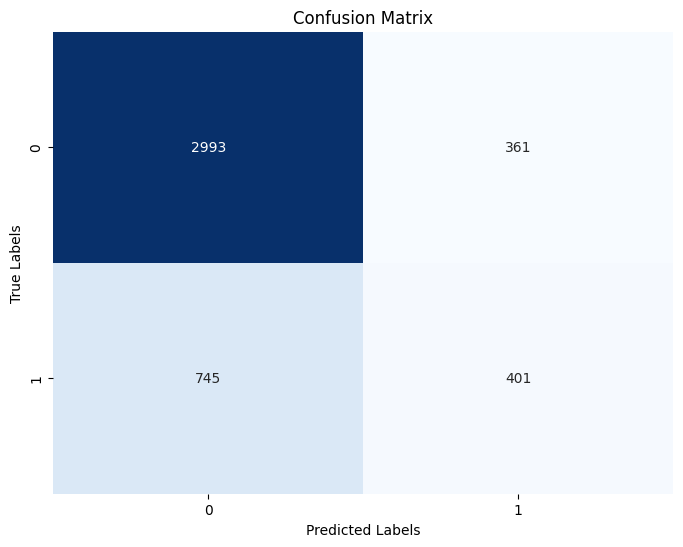

In [22]:
cm = confusion_matrix(test_labels, predictions_custom_bert)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


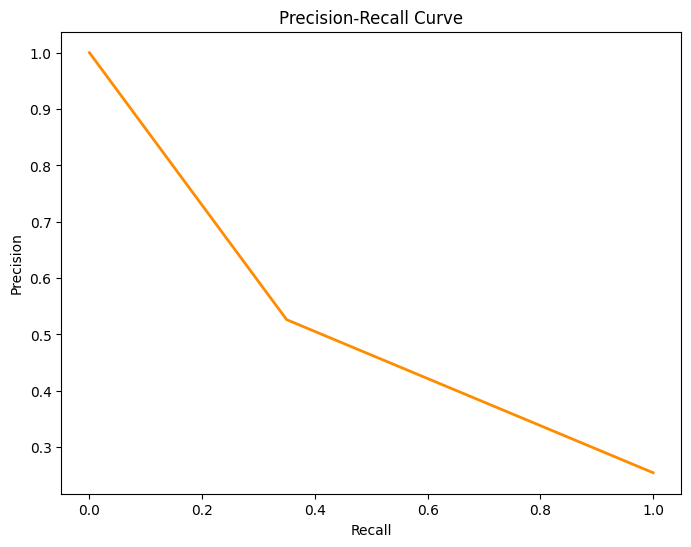

In [23]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(test_labels, predictions_custom_bert)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


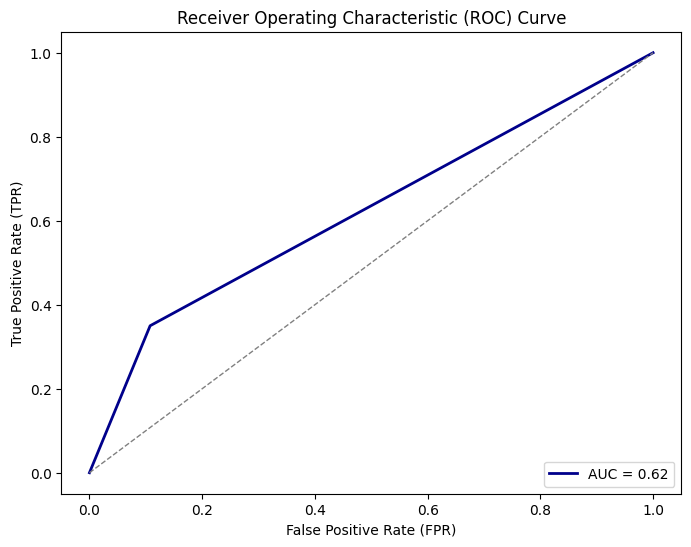

In [24]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(test_labels, predictions_custom_bert)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkblue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()